In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import gradio as gr
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("loan_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


In [4]:
for i in df.columns:
    if len(np.unique(df[i])) <= 5:
        print(i)

credit.policy
not.fully.paid


<Axes: xlabel='credit.policy', ylabel='count'>

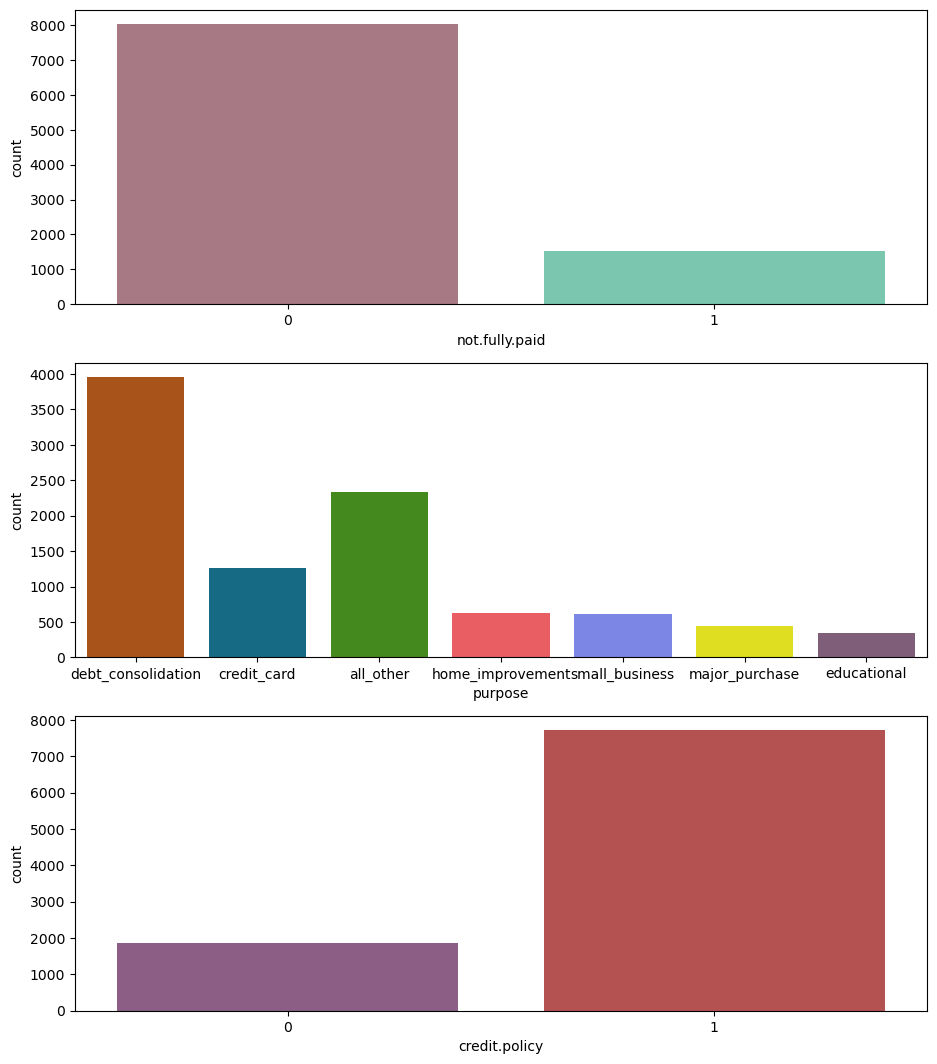

In [5]:
fig, axs = plt.subplots(nrows=3, figsize=(11,13))
sns.countplot(x="not.fully.paid", data=df, palette=['#ae7181', '#6ed3b2', '#3f9b0b'], ax = axs[0])
sns.countplot(x="purpose", data=df, palette=['#c04e01', '#047495', '#3f9b0b', '#ff474c', '#6a79f7', '#fffd01', '#84597e'], ax = axs[1])
sns.countplot(x="credit.policy", data=df, palette=['#94568c', '#c44240', '#3f9b0b'], ax = axs[2])

In [6]:
df['purpose'], labels = pd.factorize(df['purpose'])

In [7]:
df_corr = df.corr().transpose()
df_corr

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
credit.policy,1.000000,-0.017331,-0.294089,0.058770,0.034906,-0.090901,0.348319,0.099026,-0.187518,-0.104095,-0.535511,-0.076318,-0.054243,-0.158119
purpose,-0.017331,1.000000,-0.061173,-0.119683,-0.019800,-0.199278,0.144098,-0.010047,-0.031574,-0.239537,0.061419,-0.000417,-0.029831,0.044193
int.rate,-0.294089,-0.061173,1.000000,0.276140,0.056383,0.220006,-0.714821,-0.124022,0.092527,0.464837,0.202780,0.156079,0.098162,0.159552
installment,0.058770,-0.119683,0.276140,1.000000,0.448102,0.050202,0.086039,0.183297,0.233625,0.081356,-0.010419,-0.004368,-0.032760,0.049955
log.annual.inc,0.034906,-0.019800,0.056383,0.448102,1.000000,-0.054065,0.114576,0.336896,0.372140,0.054881,0.029171,0.029203,0.016506,-0.033439
dti,-0.090901,-0.199278,0.220006,0.050202,-0.054065,1.000000,-0.241191,0.060101,0.188748,0.337109,0.029189,-0.021792,0.006209,0.037362
fico,0.348319,0.144098,-0.714821,0.086039,0.114576,-0.241191,1.000000,0.263880,-0.015553,-0.541289,-0.185293,-0.216340,-0.147592,-0.149666
days.with.cr.line,0.099026,-0.010047,-0.124022,0.183297,0.336896,0.060101,0.263880,1.000000,0.229344,-0.024239,-0.041736,0.081374,0.071826,-0.029237
revol.bal,-0.187518,-0.031574,0.092527,0.233625,0.372140,0.188748,-0.015553,0.229344,1.000000,0.203779,0.022394,-0.033243,-0.031010,0.053699
revol.util,-0.104095,-0.239537,0.464837,0.081356,0.054881,0.337109,-0.541289,-0.024239,0.203779,1.000000,-0.013880,-0.042740,0.066717,0.082088


<Axes: >

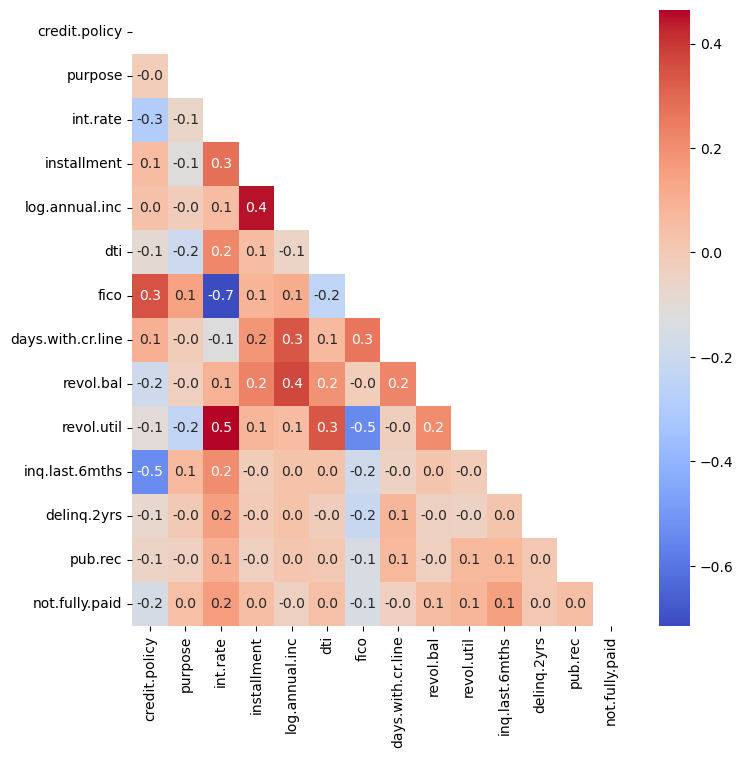

In [8]:
fig = plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask = mask, fmt = ".1f", annot = True, cmap='coolwarm')

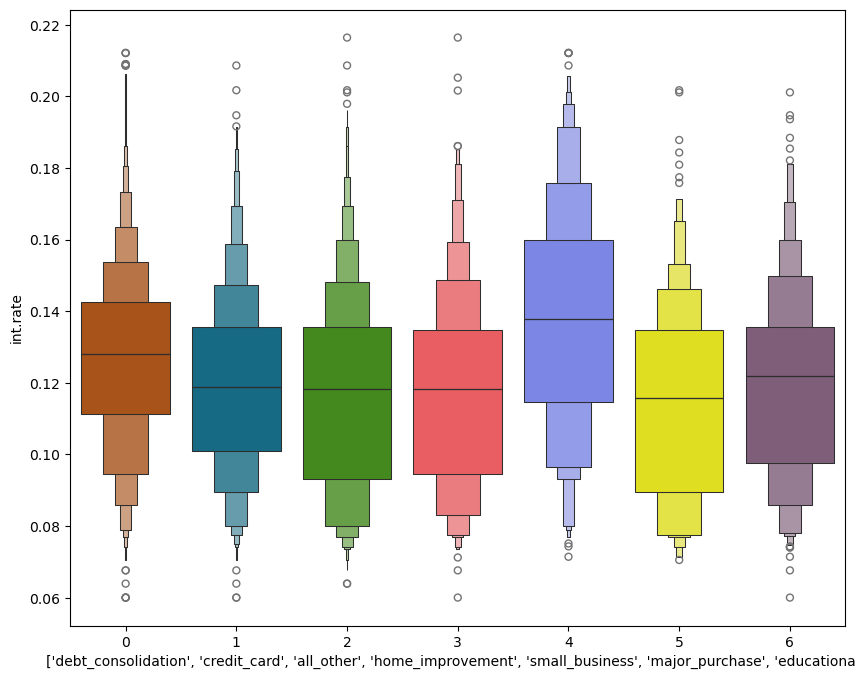

In [9]:
fig = plt.figure(figsize=(10,8))
sns.boxenplot(x="purpose", y="int.rate", data=df, palette=['#c04e01', '#047495', '#3f9b0b', '#ff474c', '#6a79f7', '#fffd01', '#84597e'])
#plt.xticks(rotation=45)
plt.xlabel(['debt_consolidation', 'credit_card', 'all_other', 'home_improvement',
       'small_business', 'major_purchase', 'educational'])
plt.show()

In [10]:
# Perform feature engineering
df["installment_to_income_ratio"] = (
    df["installment"] / df["log.annual.inc"]
)
df["credit_history"] = (df["delinq.2yrs"] + df["pub.rec"]) / df["fico"]

In [11]:
df = df.drop(['credit.policy', 'days.with.cr.line', 'purpose'], axis=1)

# Convert categorical variables to numerical using LabelEncoder

le = LabelEncoder()
df['not.fully.paid'] = le.fit_transform(df['not.fully.paid'])

In [12]:
scaler = StandardScaler()
numerical_cols = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec','credit_history','installment_to_income_ratio']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

X_resampled, y_resampled = sm.fit_resample(X, y)

df = pd.concat([X_resampled, y_resampled], axis=1)
df['not.fully.paid'].value_counts()

not.fully.paid
0    8045
1    8045
Name: count, dtype: int64

In [14]:
# class is balanced now

In [15]:

# Split the dataset into training and testing sets
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit and evaluate decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print("Decision Tree Classifier Accuracy: {:.2f}%".format(dt_score*100))

# Fit and evaluate random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print("Random Forest Classifier Accuracy: {:.2f}%".format(rf_score*100))

# Fit and evaluate logistic regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Logistic Regression Classifier Accuracy: {:.2f}%".format(lr_score*100))

# Fit and evaluate support vector machine classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print("Support Vector Machine Classifier Accuracy: {:.2f}%".format(svm_score*100))

Decision Tree Classifier Accuracy: 81.21%
Random Forest Classifier Accuracy: 89.14%
Logistic Regression Classifier Accuracy: 61.32%
Support Vector Machine Classifier Accuracy: 66.54%


In [18]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [19]:
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the testing set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Random Forest Classifier Evaluation Results:")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))
print("Best hyperparameters:", best_params)

Random Forest Classifier Evaluation Results:
Accuracy: 89.35%
Precision: 89.92%
Recall: 88.33%
F1 Score: 89.12%
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [20]:
joblib.dump(best_model, 'loan_classifier.joblib')

['loan_classifier.joblib']

In [24]:

# Load the trained model
model = joblib.load("loan_classifier.joblib")


def predict_loan_status(
    int_rate,
    installment,
    log_annual_inc,
    dti,
    fico,
    revol_bal,
    revol_util,
    inq_last_6mths,
    delinq_2yrs,
    pub_rec,
    installment_to_income_ratio,
    credit_history,
):
    input_dict = {
        "int.rate": int_rate,
        "installment": installment,
        "log.annual.inc": log_annual_inc,
        "dti": dti,
        "fico": fico,
        "revol.bal": revol_bal,
        "revol.util": revol_util,
        "inq.last.6mths": inq_last_6mths,
        "delinq.2yrs": delinq_2yrs,
        "pub.rec": pub_rec,
        "installment_to_income_ratio": installment_to_income_ratio,
        "credit_history": credit_history,
    }
    # Convert the dictionary to a 2D array
    input_array = [list(input_dict.values())]
    prediction = model.predict(input_array)[0]

    if prediction == 0:
        return "Loan fully paid"
    else:
        return "Loan not fully paid"


inputs = [
    gr.Slider(0.06, 0.23, step=0.01, label="Interest Rate"),
    gr.Slider(100, 950, step=10, label="Installment"),
    gr.Slider(7, 15, step=0.1, label="Log Annual Income"),
    gr.Slider(0, 40, step=1, label="DTI Ratio"),
    gr.Slider(600, 850, step=1, label="FICO Score"),
    gr.Slider(0, 120000, step=1000, label="Revolving Balance"),
    gr.Slider(0, 120, step=1, label="Revolving Utilization"),
    gr.Slider(0, 10, step=1, label="Inquiries in Last 6 Months"),
    gr.Slider(0, 20, step=1, label="Delinquencies in Last 2 Years"),
    gr.Slider(0, 10, step=1, label="Public Records"),
    gr.Slider(0, 5, step=0.1, label="Installment to Income Ratio"),
    gr.Slider(0, 1, step=0.01, label="Credit History"),
]
outputs = [gr.Label(num_top_classes=2)]

title = "Loan Approval Classifier"
description = (
    "Enter the details of the loan applicant to check if the loan is approved or not."
)
gr.Interface(
    fn=predict_loan_status,
    inputs=inputs,
    outputs=outputs,
    title=title,
    description=description,
).launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://92484454bd4790fc74.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
